## Decision_tree

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data = pd.read_csv('AAL.csv')

# Filter Year 1 and Year 2 data
data['Date'] = pd.to_datetime(data['Date'])
year1_data = data[data['Year'] == 2022]
year2_data = data[data['Year'] == 2023]

# Extract weekly mean and standard deviation of returns for each week in Year 1 and Year 2
def calculate_weekly_features(df):
    weekly_features = df.groupby('Year_Week').agg(
        weekly_mean=('Return', 'mean'),
        weekly_std=('Return', 'std'),
        label=('Label', 'last')  # Using the label from the last day of the week (Friday)
    ).reset_index()
    return weekly_features

year1_features = calculate_weekly_features(year1_data)
year2_features = calculate_weekly_features(year2_data)

# Prepare training and testing data
X_train = year1_features[['weekly_mean', 'weekly_std']]
y_train = year1_features['label']
X_test = year2_features[['weekly_mean', 'weekly_std']]
y_test = year2_features['label']

# Initialize Decision Tree classifier with entropy as splitting criteria
dtc = DecisionTreeClassifier(criterion='entropy')

# Train classifier on Year 1 data
dtc.fit(X_train, y_train)

# Predict on Year 2 data
y_pred_dtc = dtc.predict(X_test)

# 1. Calculate accuracy for Year 2
accuracy_dtc = accuracy_score(y_test, y_pred_dtc)
print(f"1. Decision Tree Classifier Accuracy: {accuracy_dtc}")

# 2. Calculate confusion matrix
conf_matrix_dtc = confusion_matrix(y_test, y_pred_dtc, labels=['Green', 'Red'])
print("2. Confusion Matrix for Decision Tree Classifier:")
print(conf_matrix_dtc)

# 3. Calculate TPR and TNR for Decision Tree Classifier
tp_dtc = conf_matrix_dtc[0, 0]
fn_dtc = conf_matrix_dtc[0, 1]
fp_dtc = conf_matrix_dtc[1, 0]
tn_dtc = conf_matrix_dtc[1, 1]
tpr_dtc = tp_dtc / (tp_dtc + fn_dtc)  # True Positive Rate
tnr_dtc = tn_dtc / (tn_dtc + fp_dtc)  # True Negative Rate
print(f"3. TPR (True Positive Rate): {tpr_dtc}")
print(f"   TNR (True Negative Rate): {tnr_dtc}")

# 4. Implement trading strategy based on Decision Tree predictions for Year 2 using actual returns
initial_balance = 100  # Starting with $100

def simulate_trading(predictions, weekly_returns, initial_balance=100):
    balance = initial_balance
    for pred, weekly_return in zip(predictions, weekly_returns):
        balance *= 1 + weekly_return if pred == 'Green' else 1 - weekly_return
    return balance

# Extract weekly returns for Year 2
weekly_returns = year2_features['weekly_mean']

# Calculate final balance using actual weekly returns with the Decision Tree strategy
final_balance_dtc = simulate_trading(y_pred_dtc, weekly_returns)

# Buy-and-hold strategy
buy_and_hold_balance = initial_balance * (1 + weekly_returns.mean() * 52)  # Average weekly return over the year

# 5. Strategy comparison
print(f"4. Final balance with Decision Tree strategy: ${final_balance_dtc}")
print(f"   Final balance with buy-and-hold strategy: ${buy_and_hold_balance}")


1. Decision Tree Classifier Accuracy: 1.0
2. Confusion Matrix for Decision Tree Classifier:
[[24  0]
 [ 0 28]]
3. TPR (True Positive Rate): 1.0
   TNR (True Negative Rate): 1.0
4. Final balance with Decision Tree strategy: $159.96790206205043
   Final balance with buy-and-hold strategy: $102.42078269999999


## random_forest

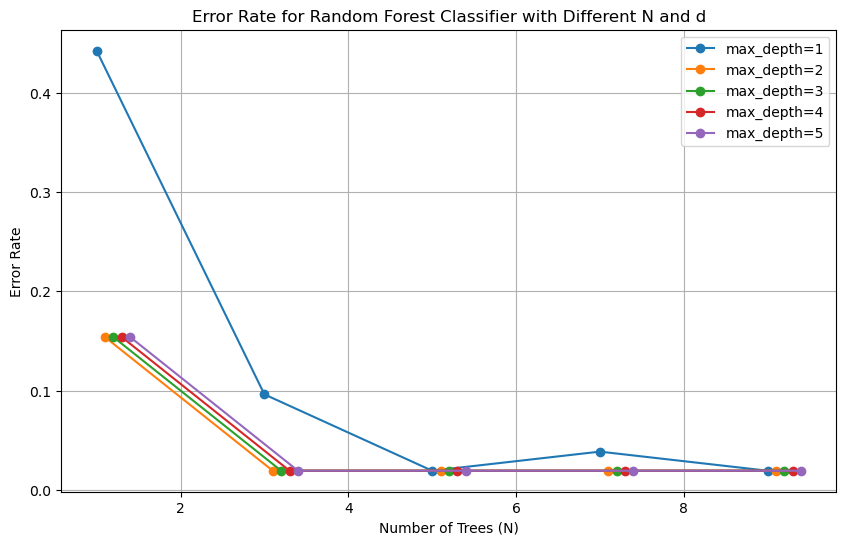

1) Optimal N: 3.0, Optimal d: 2.0
2) Confusion Matrix for Optimal Random Forest Classifier:
[[24  0]
 [ 1 27]]
3) TPR (True Positive Rate): 1.0
TNR (True Negative Rate): 0.9642857142857143


In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('AAL.csv')

# Filter Year 1 and Year 2 data
data['Date'] = pd.to_datetime(data['Date'])
year1_data = data[data['Year'] == 2022]
year2_data = data[data['Year'] == 2023]

# Extract weekly mean and standard deviation of returns for each week in Year 1 and Year 2
def calculate_weekly_features(df):
    weekly_features = df.groupby('Year_Week').agg(
        weekly_mean=('Return', 'mean'),
        weekly_std=('Return', 'std'),
        label=('Label', 'last')  # Using the label from the last day of the week (Friday)
    ).reset_index()
    return weekly_features

year1_features = calculate_weekly_features(year1_data)
year2_features = calculate_weekly_features(year2_data)

# Prepare training and testing data
X_train = year1_features[['weekly_mean', 'weekly_std']]
y_train = year1_features['label']
X_test = year2_features[['weekly_mean', 'weekly_std']]
y_test = year2_features['label']

# Hyperparameter values
N_values = [1, 3, 5, 7, 9]
d_values = [1, 2, 3, 4, 5]

# To store error rates
error_rates = []

# Iterate over hyperparameter values
for N in N_values:
    for d in d_values:
        # Initialize Random Forest classifier with specified N and d
        rf = RandomForestClassifier(n_estimators=N, max_depth=d, criterion='entropy', random_state=42)
        
        # Train classifier on Year 1 data
        rf.fit(X_train, y_train)
        
        # Predict on Year 2 data
        y_pred_rf = rf.predict(X_test)
        
        # Calculate error rate
        error_rate = 1 - accuracy_score(y_test, y_pred_rf)
        error_rates.append((N, d, error_rate))

# Convert error rates to a DataFrame for plotting
error_df = pd.DataFrame(error_rates, columns=['N', 'd', 'error_rate'])

# Plot error rates
plt.figure(figsize=(10, 6))
jitter = 0.1  # Small jitter for better visualization
for i, d in enumerate(d_values):
    subset = error_df[error_df['d'] == d]
    if not subset.empty:
        # Introduce a small jitter to N values for visualization
        plt.plot(subset['N'] + i * jitter, subset['error_rate'], marker='o', linestyle='-', label=f'max_depth={d}')
plt.xlabel('Number of Trees (N)')
plt.ylabel('Error Rate')
plt.title('Error Rate for Random Forest Classifier with Different N and d')
plt.legend()
plt.grid(True)
plt.show()

# Find optimal values of N and d with the minimum error rate
optimal_params = error_df.loc[error_df['error_rate'].idxmin()]
optimal_N = optimal_params['N']
optimal_d = optimal_params['d']
print(f"1) Optimal N: {optimal_N}, Optimal d: {optimal_d}")

# 2. Using the optimal values, train and evaluate the Random Forest Classifier on Year 2 data
rf_optimal = RandomForestClassifier(n_estimators=int(optimal_N), max_depth=int(optimal_d), criterion='entropy', random_state=42)
rf_optimal.fit(X_train, y_train)
y_pred_optimal = rf_optimal.predict(X_test)

# Confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_optimal, labels=['Green', 'Red'])
print("2) Confusion Matrix for Optimal Random Forest Classifier:")
print(conf_matrix_rf)

# True Positive Rate (TPR) and True Negative Rate (TNR)
tp_rf = conf_matrix_rf[0, 0]
fn_rf = conf_matrix_rf[0, 1]
fp_rf = conf_matrix_rf[1, 0]
tn_rf = conf_matrix_rf[1, 1]
tpr_rf = tp_rf / (tp_rf + fn_rf)  # True Positive Rate
tnr_rf = tn_rf / (tn_rf + fp_rf)  # True Negative Rate
print(f"3) TPR (True Positive Rate): {tpr_rf}")
print(f"TNR (True Negative Rate): {tnr_rf}")


### stock_naive_bayesian_custom_density

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score, confusion_matrix

# Load the data
data = pd.read_csv('AAL.csv')

# Filter Year 1 and Year 2 data
data['Date'] = pd.to_datetime(data['Date'])
year1_data = data[data['Year'] == 2022]
year2_data = data[data['Year'] == 2023]

# Extract weekly mean and standard deviation of returns for each week in Year 1 and Year 2
def calculate_weekly_features(df):
    weekly_features = df.groupby('Year_Week').agg(
        weekly_mean=('Return', 'mean'),
        weekly_std=('Return', 'std'),
        label=('Label', 'last')  # Using the label from the last day of the week (Friday)
    ).reset_index()
    return weekly_features

year1_features = calculate_weekly_features(year1_data)
year2_features = calculate_weekly_features(year2_data)

# Prepare training and testing data
X_train = year1_features[['weekly_mean', 'weekly_std']].values
y_train = year1_features['label'].values
X_test = year2_features[['weekly_mean', 'weekly_std']].values
y_test = year2_features['label'].values

# Function to estimate Student-t distribution parameters
def estimate_student_t_params(x):
    df, location, scale = stats.t.fit(x)
    return df, location, scale

# Student-t Naive Bayesian Classifier
def student_t_naive_bayes(X_train, y_train, X_test, df_values):
    unique_labels = np.unique(y_train)
    predictions = []
    
    for df_value in df_values:
        params = {label: {'df': [], 'location': [], 'scale': []} for label in unique_labels}

        # Estimate distribution parameters for each label
        for label in unique_labels:
            subset = X_train[y_train == label]
            for i in range(subset.shape[1]):
                # Fit without specifying 'df' in the fit method
                df, loc, scale = stats.t.fit(subset[:, i])
                params[label]['df'].append(df_value)  # Override with the fixed df_value
                params[label]['location'].append(loc)
                params[label]['scale'].append(scale)

        # Make predictions
        y_pred = []
        for x in X_test:
            label_probs = {}
            for label in unique_labels:
                prob = 1
                for i in range(len(x)):
                    df, loc, scale = params[label]['df'][i], params[label]['location'][i], params[label]['scale'][i]
                    prob *= stats.t.pdf(x[i], df, loc, scale)
                label_probs[label] = prob
            y_pred.append(max(label_probs, key=label_probs.get))
        predictions.append((df_value, y_pred))
    return predictions

# Evaluate model and print results
df_values = [0.5, 1, 5]
predictions = student_t_naive_bayes(X_train, y_train, X_test, df_values)

for df_value, y_pred in predictions:
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n1,2,3)Accuracy for df = {df_value}: {accuracy}")
    conf_matrix = confusion_matrix(y_test, y_pred, labels=['Green', 'Red'])
    print(f"Confusion Matrix for df = {df_value}:\n{conf_matrix}")
    tp = conf_matrix[0, 0]
    fn = conf_matrix[0, 1]
    fp = conf_matrix[1, 0]
    tn = conf_matrix[1, 1]
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    print(f"True Positive Rate (TPR): {tpr}")
    print(f"True Negative Rate (TNR): {tnr}")

# Determine the best df value based on accuracy
best_df_value, best_y_pred = max(predictions, key=lambda item: accuracy_score(y_test, item[1]))
print(f"\n4)Best df value: {best_df_value}")

# Trading Strategy Comparison
initial_balance = 100

def simulate_trading(predictions, weekly_returns, initial_balance=100):
    balance = initial_balance
    for pred, weekly_return in zip(predictions, weekly_returns):
        balance *= 1 + weekly_return if pred == 'Green' else 1 - weekly_return
    return balance

weekly_returns = year2_features['weekly_mean']
final_balance_strategy = simulate_trading(best_y_pred, weekly_returns)
buy_and_hold_balance = initial_balance * (1 + weekly_returns.mean() * 52)

print(f"5)Final balance with Student-t Naive Bayes strategy: ${final_balance_strategy}")
print(f"Final balance with buy-and-hold strategy: ${buy_and_hold_balance}")



1,2,3)Accuracy for df = 0.5: 0.9807692307692307
Confusion Matrix for df = 0.5:
[[24  0]
 [ 1 27]]
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.9642857142857143

1,2,3)Accuracy for df = 1: 0.9807692307692307
Confusion Matrix for df = 1:
[[24  0]
 [ 1 27]]
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.9642857142857143

1,2,3)Accuracy for df = 5: 0.9038461538461539
Confusion Matrix for df = 5:
[[24  0]
 [ 5 23]]
True Positive Rate (TPR): 1.0
True Negative Rate (TNR): 0.8214285714285714

4)Best df value: 0.5
5)Final balance with Student-t Naive Bayes strategy: $159.55200957712646
Final balance with buy-and-hold strategy: $102.42078269999999
